<img src='./world_cup_2018.jpeg'>

<style>
h1, h2{
    font-weight: bold
}
</style>


<h1>FIFA WORLD CUP</h1>
<p>The FIFA World Cup is the most watched tournament in football. The Fédération Internationale de Football Association (FIFA) organises the World Cup every four years. More people watch the World Cup finals than any other sporting event in the world—even more people than the Olympic Games. One of the most prestigious prizes in the tournment is the 'Man of the Match' award, given at the end of each game.</p>
<p> In this notebook, we will build a model that will predict the 'Man of the Match' for each game.
First, we will start exploring the data for interesting information. </p>


<h2> Importing Libraries</h2>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import skew
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap


In [8]:
file_path = './FIFA_2018_Statistics.csv'
df = pd.read_csv(file_path)

<h2> We divided our data into two categories:</h2>
<ul>
    <li>Numercial columns: Numerical Data type</li>
    <li>Categorical columns: Object(including strings) Data type</li>
</ul>

In [9]:
cat_cols = df.select_dtypes(include=[np.object]).columns
num_cols = df.select_dtypes(include=[np.number]).columns

<h2> A first look on our data</h2>
<ul>
    <li>A simple describtion can be a great first step in understanding a dataset. </li>
</ul>

In [4]:
df.describe()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,...,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,1st Goal,Goals in PSO,Own goals,Own goal Time
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,94.000000,128.000000,12.0,12.000000
mean,1.320312,49.992188,12.593750,3.914062,5.273438,3.359375,4.718750,1.343750,14.890625,2.726562,...,462.648438,106.664062,13.546875,1.695312,0.015625,0.015625,39.457447,0.203125,1.0,45.833333
std,1.156519,10.444074,5.245827,2.234403,2.409675,2.403195,2.446072,1.193404,4.724262,2.049447,...,151.186311,11.749537,4.619131,1.325454,0.124507,0.124507,24.496506,0.807049,0.0,29.978275
min,0.000000,25.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,189.000000,80.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,12.000000
25%,0.000000,42.000000,9.000000,2.000000,4.000000,1.750000,3.000000,0.000000,11.000000,1.000000,...,351.000000,101.000000,10.000000,1.000000,0.000000,0.000000,18.250000,0.000000,1.0,21.750000
50%,1.000000,50.000000,12.000000,3.500000,5.000000,3.000000,5.000000,1.000000,15.000000,2.000000,...,462.000000,104.500000,13.000000,2.000000,0.000000,0.000000,39.000000,0.000000,1.0,35.000000
75%,2.000000,58.000000,15.000000,5.000000,7.000000,4.000000,6.000000,2.000000,18.000000,4.000000,...,555.250000,109.000000,16.000000,2.000000,0.000000,0.000000,54.750000,0.000000,1.0,75.750000
max,6.000000,75.000000,26.000000,12.000000,11.000000,10.000000,11.000000,5.000000,26.000000,9.000000,...,1137.000000,148.000000,25.000000,6.000000,1.000000,1.000000,90.000000,4.000000,1.0,90.000000


<ul>
<li>further details can be extracted from a historgram</li>
</ul>

[]

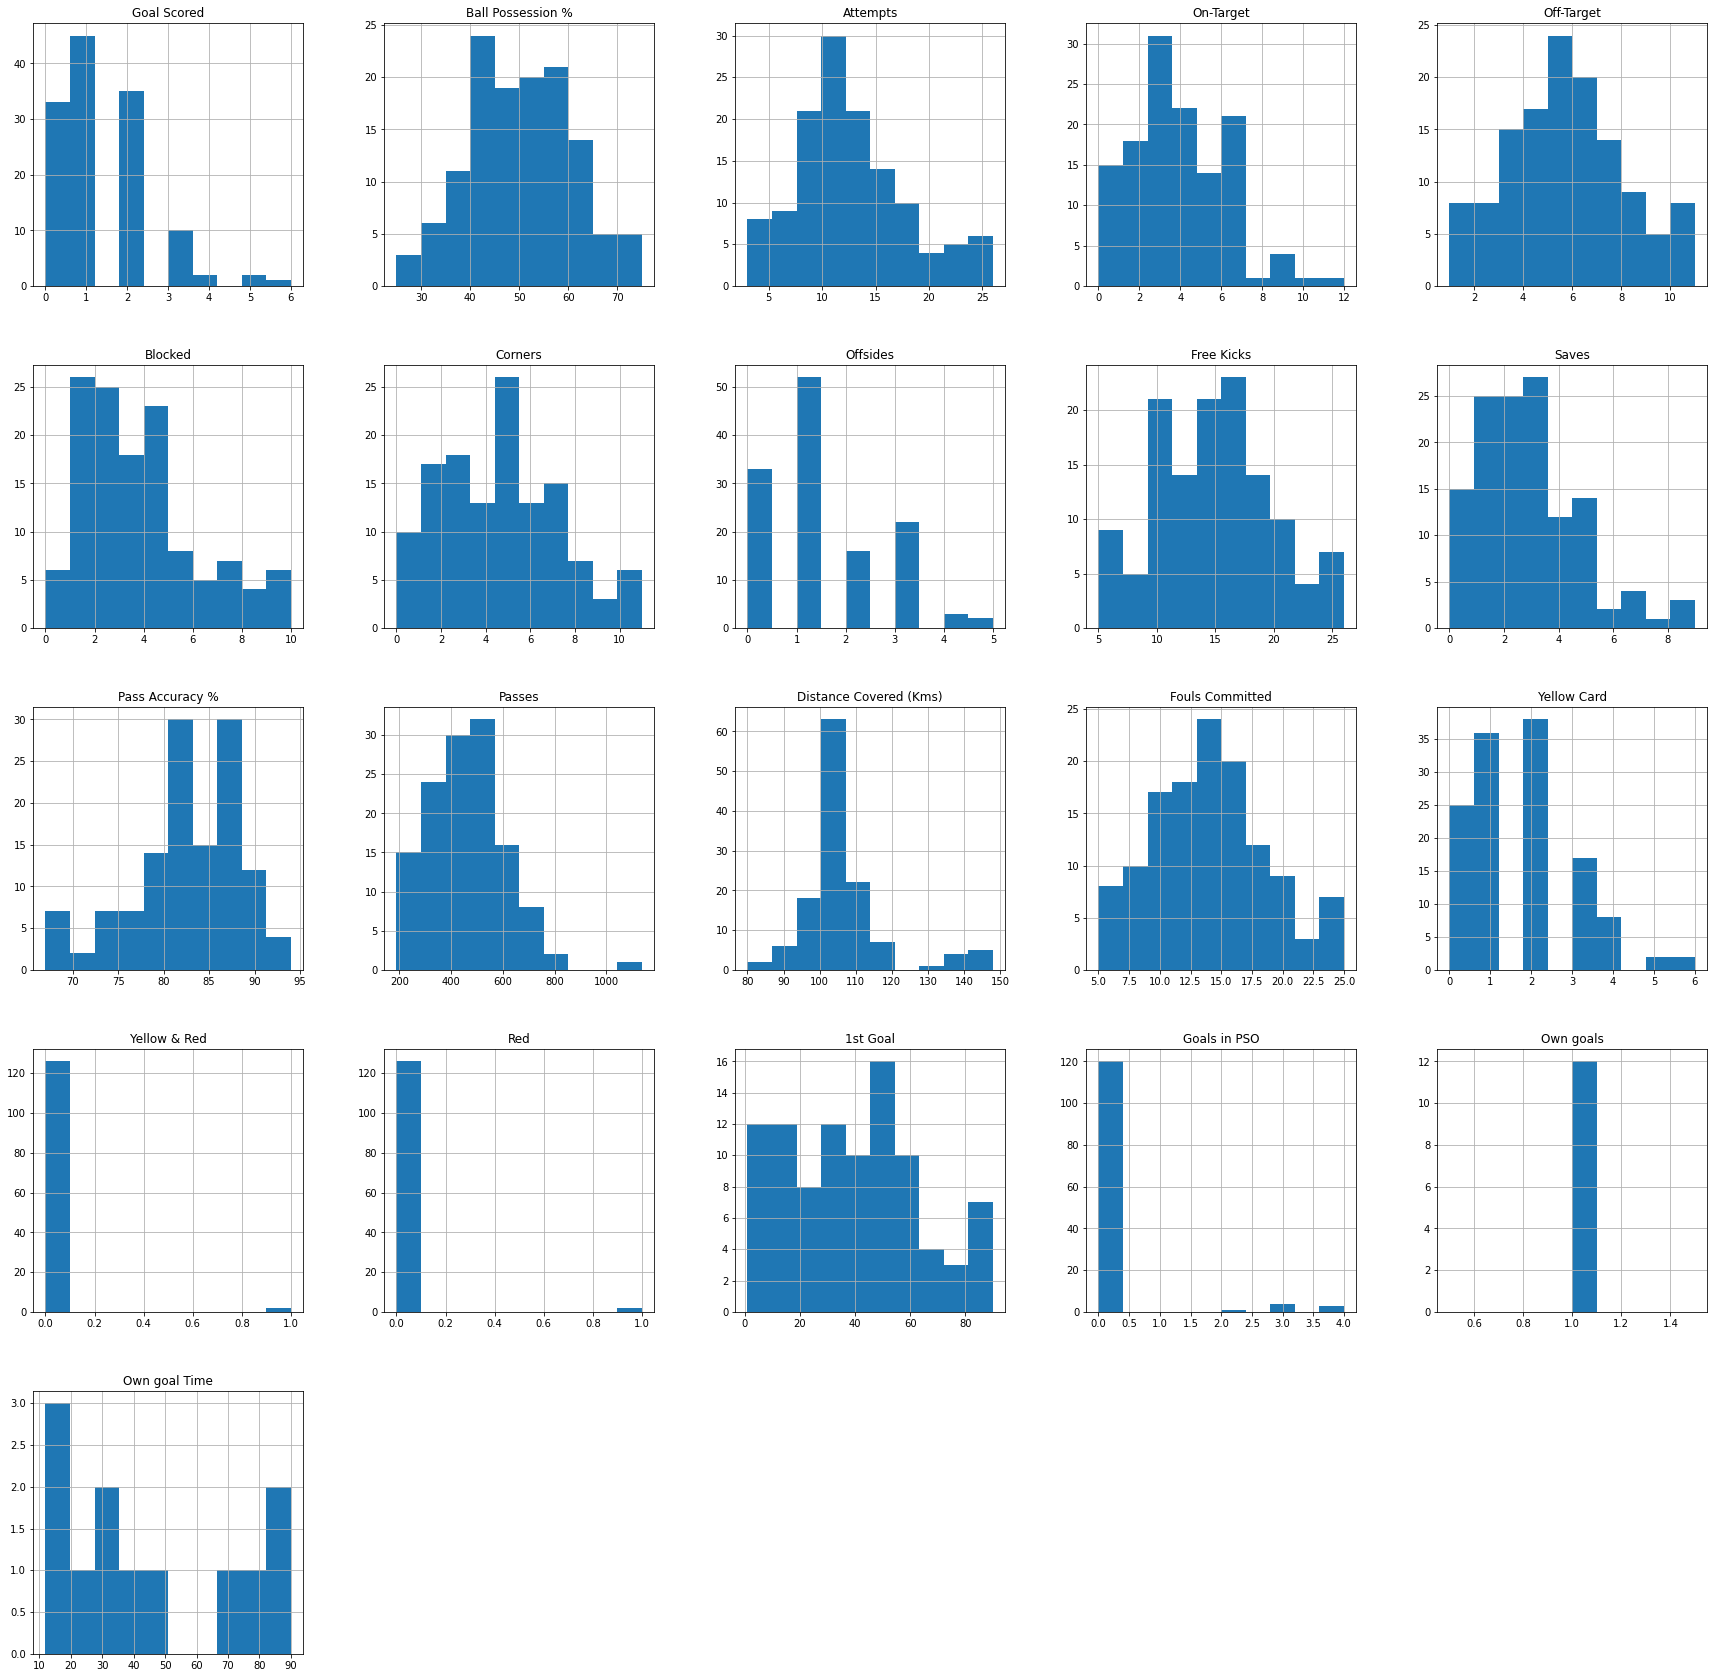

In [4]:
df.hist(figsize=(30, 30))
plt.plot()

In [5]:
skew_values = skew(df[num_cols], nan_policy='omit')
pd.concat([pd.DataFrame(list(df[num_cols]), columns=['Features']),
pd.DataFrame(list(skew_values), columns=['Skewness degree'])], axis=1)

,Features,Skewness degree
0,Goal Scored,1.132232
1,Ball Possession %,0.002204
2,Attempts,0.645828
3,On-Target,0.792629
4,Off-Target,0.279919
5,Blocked,0.942771
6,Corners,0.302464
7,Offsides,0.819830
8,Free Kicks,0.098830
9,Saves,0.934101


<p>For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function skewtest can be used to determine if the skewness value is close enough to 0.

Although data is not normally distribute, there are positive as well have negative skewedness
</p>

<h2> Inspecting our data for missing values</h2>

In [6]:
missing_values = df.isnull().sum().sort_values(ascending=False)
percentage_missing_values = (missing_values/len(df)) * 100
pd.concat([missing_values, percentage_missing_values], axis=1, keys=['Missing Values', 'Missing %'])



,Missing Values,Missing %
Own goal Time,116,90.6250
Own goals,116,90.6250
1st Goal,34,26.5625
Free Kicks,0,0.0000
Team,0,0.0000
Opponent,0,0.0000
Goal Scored,0,0.0000
Ball Possession %,0,0.0000
Attempts,0,0.0000
On-Target,0,0.0000


In [10]:
# Convert 'Man of the Match' from Yes/No to binary 1/0
str_to_bnry = {
    'Yes': 1,
    'No': 0
}
df['Man of the Match'] = df['Man of the Match'].apply(lambda x: str_to_bnry[x])

<h2>Bivariate Analysis</h2>

<h3>To further understand our data, the relationship between featrues, we will be using some statistics tools</h3>
<ul>
    The most commonly used:
        <li> Pearson Correlation</li>
        <li> PairPlot</li>
</ul>


<h3>Pearson Coefficient</h3>
<p>The Pearson coefficient is a type of correlation coefficient that represents the relationship between two variables.
In other words, it is a measure of the strength of the association between two continuous variables. </p>
<ul>
    <li>Pearson coefficients range from +1 to -1, with +1 representing a positive correlation, -1 representing a negative correlation, and 0 representing no relationship.</li>
</ul>

<AxesSubplot:>

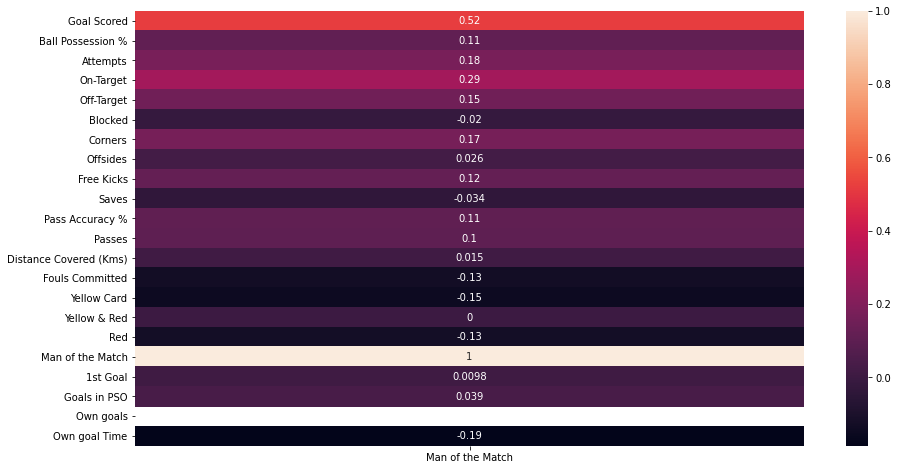

In [8]:
corr = df.corr()
corr = corr.filter(items=['Man of the Match'])
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True)

<h3>Pairplot</h3>
<p>With one single line, we can plot this powerful graph.
At the diagonal, the graphs are depicting a density plot.
Every other plot, portrait the relationship between the variables trough a scatter plot.
with a categorical variable, 'Man of the Match', as a hue.
</p>

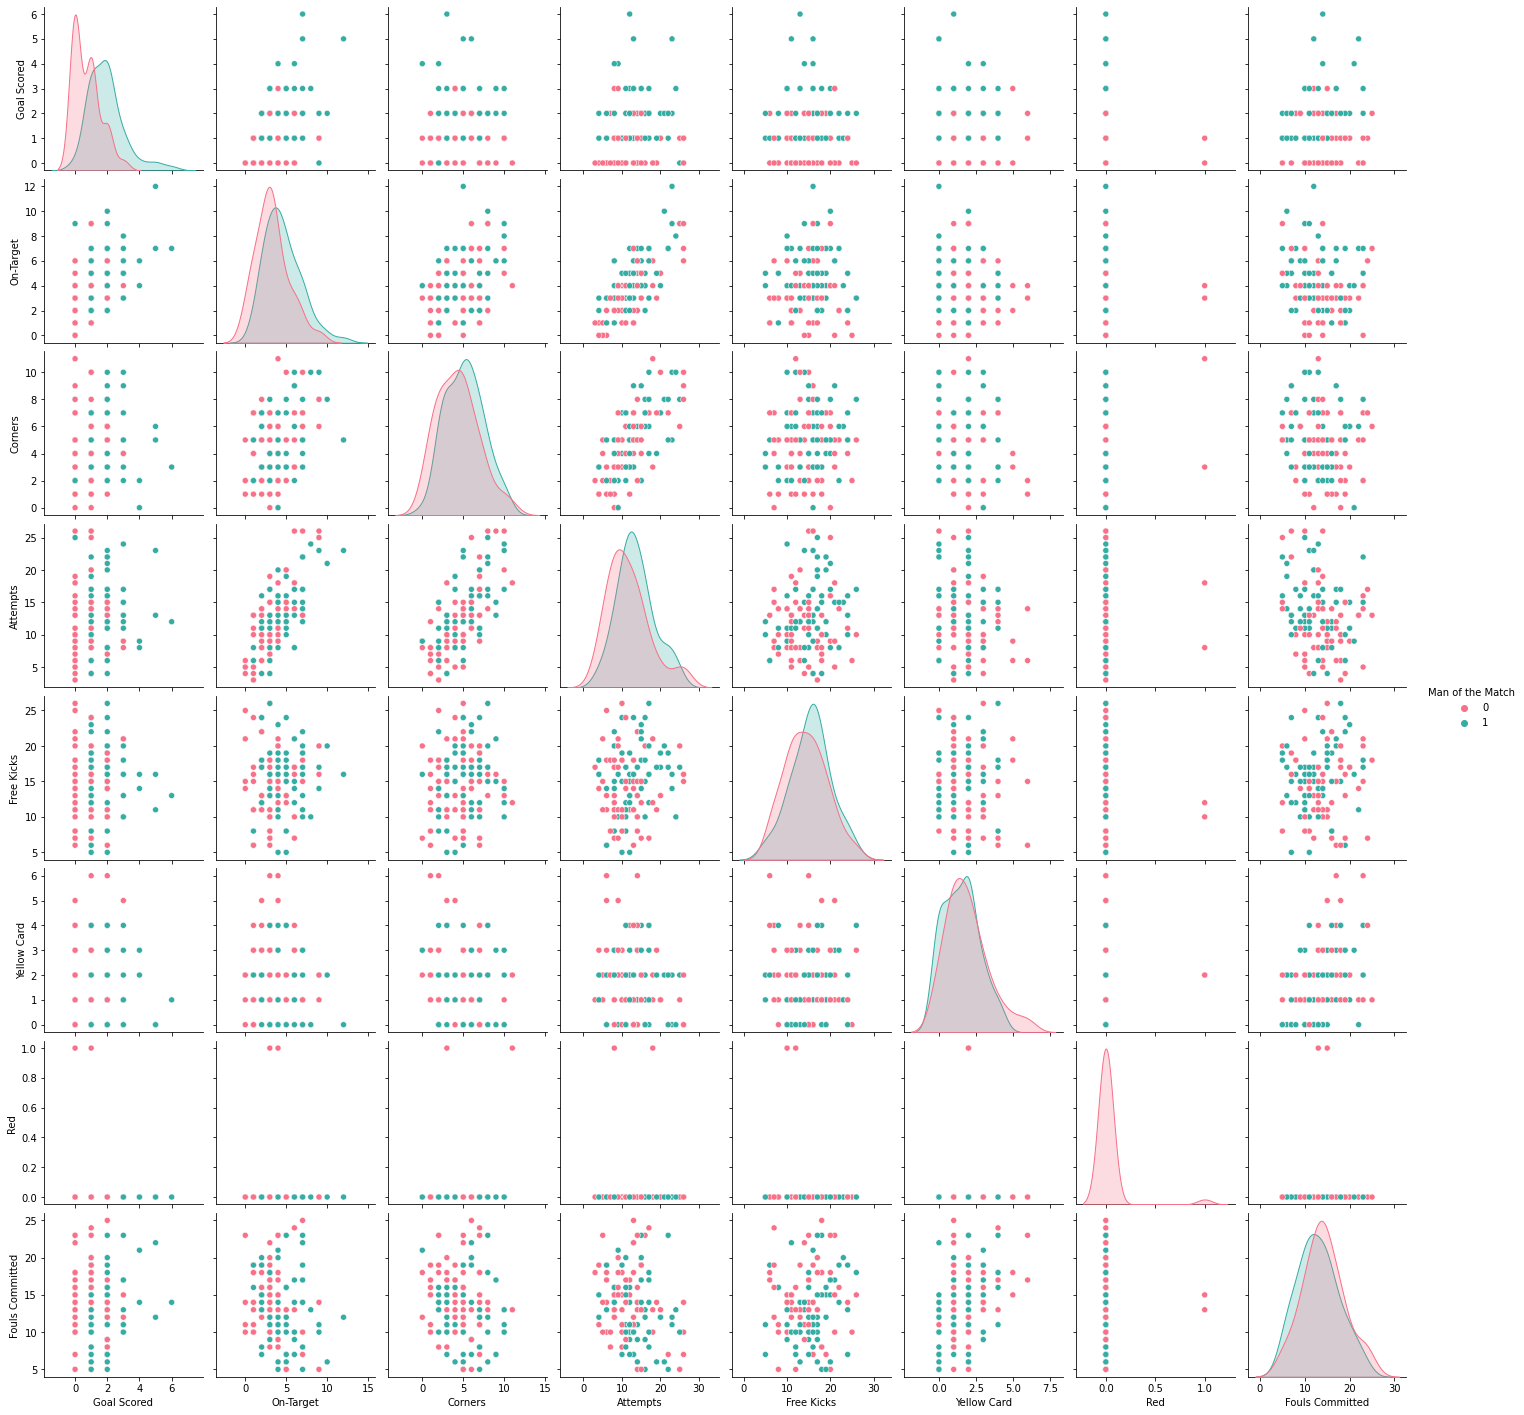

In [9]:
highest_corr = ['Goal Scored', 'On-Target', 'Corners', 'Attempts', 'Free Kicks', 'Yellow Card', 'Red', 'Fouls Committed']
highest_corr.append('Man of the Match')
sns.pairplot(df[highest_corr], hue = 'Man of the Match', palette="husl")
plt.show()



<h3>Outlier detection</h3>

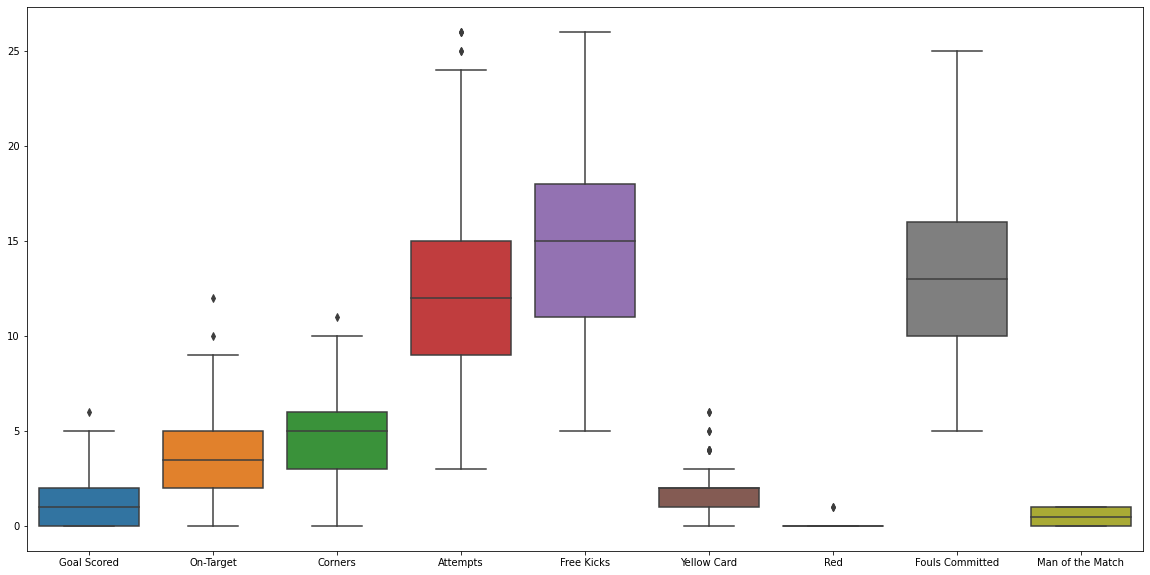

In [10]:
dummy = df[highest_corr]
plt.figure(figsize=(20, 10))
sns.boxplot(data=dummy)
plt.show()

<h3>Missing values treatment</h3>
<p> As 'own Goal Time' and 'Own goals' are having > 90% missing values, filling them with any combination will lead predictive model to false direction. So, dropping them is the best option.
I will also drop '1st Goal' columns, because it is negligebly correlated with 'Man of the Match', hence, dropping this should not have any impact
</p>

In [11]:
df.drop(['Own goal Time', 'Own goals', '1st Goal'], axis=1, inplace=True)

<h3>Categorical features encoding</h3>
<ul>
<li> As machine laearning models understand only numbers data in different formats including text and dates needs to be mapped into numbers prior to feeding to the model</li> 
<li> The process of changing non-numerical data into numerical is called 'Encoding'</li>
<li> Before encoding let's understand how many categories or levels are present in each categorical features</li>
</ul>

<p>In this function 'unique_cat_cols', I will be listing the various unique values of each categorical columns before encoding them.</p>

In [12]:
def unique_cat_cols(data_frame):
    columns = data_frame.columns.tolist().copy()
    for col in columns:
        print('Feature {} has {} unique values: {}'.format(
            col, data_frame[col].nunique(), data_frame[col].unique().tolist()
        ))
        print('\n')

<p>We are also going to drop the 'Date' column as it dhould definately not impact a player performance and more columns having lowe correlation with 'Man of the Match'</p>

In [13]:
df.drop('Date', axis=1, inplace=True)

In [14]:
df.drop(['Corners', 'Fouls Committed', 'On-Target'], axis = 1, inplace=True)



In [15]:
cleaned_data = pd.get_dummies(df)

In [16]:
y = cleaned_data['Man of the Match']
X = cleaned_data.drop(['Man of the Match'], axis=1)


In [17]:
# numerical_transfomers = SimpleImputer(strategy='constant')
# categorical_transfomers = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('one_hot', OneHotEncoder(handle_unknown='ignore'))
# ])


In [18]:
# preprocessor = ColumnTransformer(transformers=[
#     ('num', numerical_transfomers, num_cols.tolist().remove('Man of the Match')),
#     ('cat', categorical_transfomers, cat_cols)
# ])

In [17]:
my_model = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# my_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', my_model)
# ])


In [22]:
def cross_val(model, X, y, n_cv=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    mean_score = list()
    n_fold = X_train.shape[0] // n_cv
    for i in range(n_cv):
        X_val_1 = X_train.iloc[ i * n_fold: (i + 1) * n_fold]
        y_val_1 = y_train.iloc[i * n_fold: (i + 1) * n_fold]
        X_train_1 = pd.concat([X_train.iloc[:i*n_fold], X_train.iloc[(i+1) * n_fold:]], axis=0)
        y_train_1 = pd.concat([y_train.iloc[:i*n_fold], y_train.iloc[(i+1) * n_fold:]], axis=0)
        model.fit(X_train_1, y_train_1,
                early_stopping_rounds=5,
                eval_set=[(X_val_1, y_val_1)],
                verbose=False)
        mean_score.append(model.score(X_test, y_test))
    return mean_score, np.asarray(mean_score).mean()

In [55]:
print(cross_val(my_model, X, y))

([0.6538461538461539, 0.8076923076923077, 0.6538461538461539, 0.7307692307692307, 0.7307692307692307], 0.7153846153846154)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


<h2>SHAP Values</h2>
<p>Machine learning models are seen like a black box. The output is given without any information on how the model has taken this desicion.
SHAP values can help us with this problem.
In the exmaple shown below.
We can find that the probabilty that the team will be awarded with 'Man of the Match' is 0.48
(0.52 won't get it)
The main feature that lower that probabilty is 'Goal Scored', in this case 0, which is logical since 'Man of the Match' is highly correlated with this feature.
</p>


In [51]:
row_to_show = 12
data_for_prediction = X_test.iloc[row_to_show]
k_explainer = shap.KernelExplainer(my_model.predict_proba, X_train)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)